In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import losses, optimizers
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics



In [ ]:
# reading all csv files
def read_file(file) :
    df = pd.read_csv(file)
    return df 

#return null values percentage
def null_percentage(df):
    return  100 * (df.isnull().sum()/len(df))

# duplicate values
def duplicate_values(df):
    return df.drop_duplicates()

#get value counts
def value_counts(df):
    for feature in df.columns: # Loop through all columns in the dataframe
        print(df[feature].value_counts(),'\n---------------------------------------',)
        
#has special characters
def has_special_char(df):
    for feature in df.columns:
        if (df[feature].dtype == 'object' ): 
            unwanted = string.ascii_letters + string.punctuation + string.whitespace + string.digits
            print(df[df[feature].str.strip(unwanted).astype(bool)==True])

# impute missing values by median
def impute_missing_by_median(df, include):
    for feature in df.columns: # Loop through all columns in the dataframe
        if (feature in include ): # Only apply for columns with categorical strings
            df[feature]=df[feature].fillna(df[feature].median()) # Impute missing By Median
    return df

# drop missing values
def drop_missing_rows(df, feature):
    df.dropna(subset= feature, inplace=True)
    return df



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PROJECT OBJECTIVE: To build a classifier which can use the given parameters to determine the signal strength or quality. 

Steps and tasks: [ Total Score: 30 Marks]

CONTEXT: A communications equipment manufacturing company has a product which is responsible for emitting informative signals. Company wants to build a machine learning model which can help the company to predict the equipment’s signal quality using various parameters.
• DATA DESCRIPTION: The data set contains information on various signal tests performed:
1. Parameters: Various measurable signal parameters.
2. Signal_Quality: Final signal strength or quality


1. Data Import and Exploration [5 Marks]

A. Read the .h5 file and assign to a variable. [2 Marks]

In [ ]:
signalDF = read_file('/content/drive/MyDrive/ML/PythonCourse/Signals.csv')

In [ ]:
signalDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Parameter 1      1599 non-null   float64
 1   Parameter 2      1599 non-null   float64
 2   Parameter 3      1599 non-null   float64
 3   Parameter 4      1599 non-null   float64
 4   Parameter 5      1599 non-null   float64
 5   Parameter 6      1599 non-null   float64
 6   Parameter 7      1599 non-null   float64
 7   Parameter 8      1599 non-null   float64
 8   Parameter 9      1599 non-null   float64
 9   Parameter 10     1599 non-null   float64
 10  Parameter 11     1599 non-null   float64
 11  Signal_Strength  1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


***

The signal dataframe contains 12 attributes and 1599 observation. All attributes are float except the target variable signal_strength which is of int type

***

B. Check for missing values and print percentage for each attribute. [2 Marks]


In [ ]:
null_percentage(signalDF)

Parameter 1        0.0
Parameter 2        0.0
Parameter 3        0.0
Parameter 4        0.0
Parameter 5        0.0
Parameter 6        0.0
Parameter 7        0.0
Parameter 8        0.0
Parameter 9        0.0
Parameter 10       0.0
Parameter 11       0.0
Signal_Strength    0.0
dtype: float64

***

There are no any missing values, as shown above the null percentage is 0 for all of the features.

***

C. Check for presence of duplicate records in the dataset and impute with appropriate method. [2 Marks]


In [ ]:
duplicate = signalDF[signalDF.duplicated()]
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,Parameter 11,Signal_Strength
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


In [ ]:
signalDF = duplicate_values(signalDF)

In [ ]:
signalDF.shape

(1359, 12)

***

There are 240 duplicate observation. After removing duplicates there are 1359 observations in total.

***

D. Visualise distribution of the target variable. [2 Marks]


In [ ]:
sig_stg = signalDF.groupby('Signal_Strength')['Signal_Strength'].count()

<Axes: xlabel='Signal_Strength'>

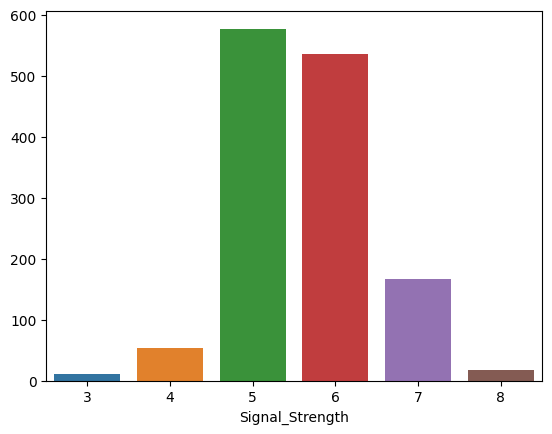

In [ ]:
sns.barplot(x=sig_stg.index, y=sig_stg.values)

***
Signal strength categories 3, 4, 7 & 8 has very infrequent values and the category '5' seems to be quite popular, '6' also seems to be popular
***

E. Share insights from the initial data analysis (at least 2). [2 Marks]

In [ ]:
signalDF.describe()

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,Parameter 11,Signal_Strength
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,2.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,2.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,3.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,3.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,5.000000


<Axes: >

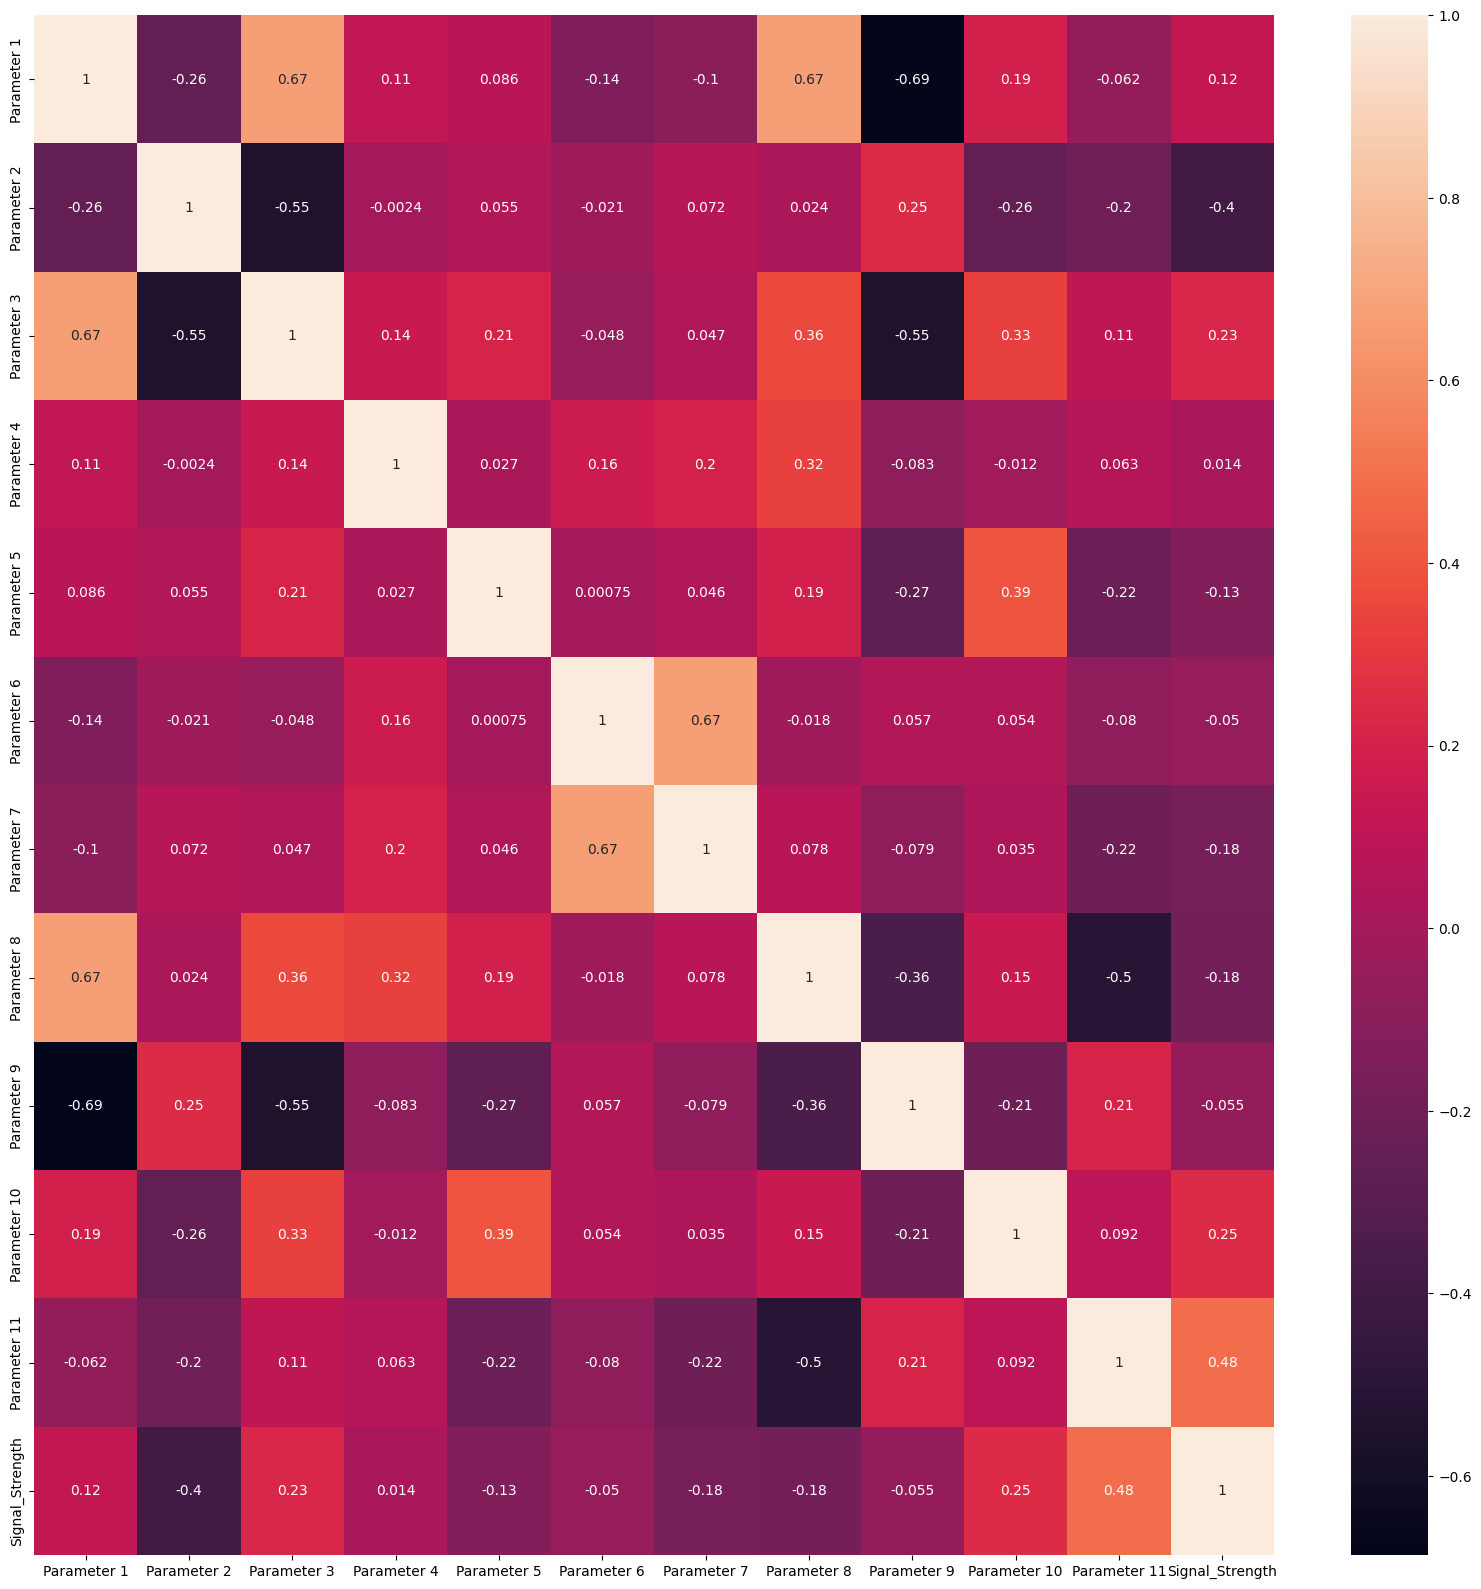

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(signalDF.corr(), annot=True)
#print(signalDF.corr())

***
**Observations:**

There are no null values in the dataset.

240 records in the dataset are duplicates.

The median of parameters 4, 6, and 7 is closer to Q1, so the distribution is right-skewed and the larger values of max indicate the presence of outliers.

There is no sign of strong linear correlation among the features, but there is a notable correlation between parameter 1 and parameters 8 and 9 of 67 and 69 percent, respectively.

***

2. Data preprocessing [7 Marks]  

A. Split the data into X & Y. [1 Marks]

In [ ]:
signalDF["Signal_Strength"]= signalDF['Signal_Strength']-3
X_signal = signalDF.drop(['Signal_Strength'], axis=1)
y_signal =signalDF['Signal_Strength']

***

Signal strength is ranging from 3 to 8, here I am subtracting with 3, so that the range is from 0 to 5.

Splitted the data X_signal and y_signal.

***

B. Split the data into train & test with 70:30 proportion.[1 Marks]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_signal ,y_signal , test_size=0.3, random_state=42)

In [ ]:
print(np.round((len(X_train)/len(signalDF.index)) * 100,2), "% data is in training set")
print(np.round((len(X_test)/len(signalDF.index)) * 100,2), "% data is in test set")

69.98 % data is in training set
30.02 % data is in test set


C. Print shape of all the 4 variables and verify if train and test data is in sync. [1 Marks] 


In [ ]:
print('Shape of X_train',X_train.shape)
print('Shape of X_test',X_test.shape)
print('Shape of y_train',y_train.shape)
print('Shape of y_test',y_test.shape)

Shape of X_train (951, 11)
Shape of X_test (408, 11)
Shape of y_train (951, 6)
Shape of y_test (408,)


In [ ]:
print("Original Signal_Strength  = 3  count  #",(signalDF[signalDF['Signal_Strength'] == 0].shape[0]),'(',round(((signalDF[signalDF['Signal_Strength'] == 0].shape[0]))/((signalDF.shape[0]))*100,2),'%)') 
print("Original Signal_Strength  = 4  count  #",(signalDF[signalDF['Signal_Strength'] == 1].shape[0]),'(',round(((signalDF[signalDF['Signal_Strength'] == 1].shape[0]))/((signalDF.shape[0]))*100,2),'%)') 
print("Original Signal_Strength  = 5  count  #",(signalDF[signalDF['Signal_Strength'] == 2].shape[0]),'(',round(((signalDF[signalDF['Signal_Strength'] == 2].shape[0]))/((signalDF.shape[0]))*100,2),'%)') 
print("Original Signal_Strength  = 6  count  #",(signalDF[signalDF['Signal_Strength'] == 3].shape[0]),'(',round(((signalDF[signalDF['Signal_Strength'] == 3].shape[0]))/((signalDF.shape[0]))*100,2),'%)') 
print("Original Signal_Strength  = 7  count  #",(signalDF[signalDF['Signal_Strength'] == 4].shape[0]),'(',round(((signalDF[signalDF['Signal_Strength'] == 4].shape[0]))/((signalDF.shape[0]))*100,2),'%)') 
print("Original Signal_Strength  = 8  count  #",(signalDF[signalDF['Signal_Strength'] == 5].shape[0]),'(',round(((signalDF[signalDF['Signal_Strength'] == 5].shape[0]))/((signalDF.shape[0]))*100,2),'%)') 
print("\nTrain Signal_Strength  = 3  count  #",(y_train[y_train[:] == 0].shape[0]),'(',round(((y_train[y_train[:] == 0].shape[0]))/((y_train.shape[0]))*100,2),'%)') 
print("Train Signal_Strength  = 4  count  #",(y_train[y_train[:] == 1].shape[0]),'(',round(((y_train[y_train[:] == 1].shape[0]))/((y_train.shape[0]))*100,2),'%)') 
print("Train Signal_Strength  = 5  count  #",(y_train[y_train[:] == 2].shape[0]),'(',round(((y_train[y_train[:] == 2].shape[0]))/((y_train.shape[0]))*100,2),'%)') 
print("Train Signal_Strength  = 6  count  #",(y_train[y_train[:] == 3].shape[0]),'(',round(((y_train[y_train[:] == 3].shape[0]))/((y_train.shape[0]))*100,2),'%)') 
print("Train Signal_Strength  = 7  count  #",(y_train[y_train[:] == 4].shape[0]),'(',round(((y_train[y_train[:] == 4].shape[0]))/((y_train.shape[0]))*100,2),'%)') 
print("Train Signal_Strength  = 8  count  #",(y_train[y_train[:] == 5].shape[0]),'(',round(((y_train[y_train[:] == 5].shape[0]))/((y_train.shape[0]))*100,2),'%)') 
print("\nTest Signal_Strength  = 3  count  #",(y_test[y_test[:] == 0].shape[0]),'(',round(((y_test[y_test[:] == 0].shape[0]))/((y_test.shape[0]))*100,2),'%)') 
print("Test Signal_Strength  = 4  count  #",(y_test[y_test[:] == 1].shape[0]),'(',round(((y_test[y_test[:] == 1].shape[0]))/((y_test.shape[0]))*100,2),'%)') 
print("Test Signal_Strength  = 5  count  #",(y_test[y_test[:] == 2].shape[0]),'(',round(((y_test[y_test[:] == 2].shape[0]))/((y_test.shape[0]))*100,2),'%)') 
print("Test Signal_Strength  = 6  count  #",(y_test[y_test[:] == 3].shape[0]),'(',round(((y_test[y_test[:] == 3].shape[0]))/((y_test.shape[0]))*100,2),'%)') 
print("Test Signal_Strength  = 7  count  #",(y_test[y_test[:] == 4].shape[0]),'(',round(((y_test[y_test[:] == 4].shape[0]))/((y_test.shape[0]))*100,2),'%)') 
print("Test Signal_Strength  = 8  count  #",(y_test[y_test[:] == 5].shape[0]),'(',round(((y_test[y_test[:] == 5].shape[0]))/((y_test.shape[0]))*100,2),'%)') 


Original Signal_Strength  = 3  count  # 10 ( 0.74 %)
Original Signal_Strength  = 4  count  # 53 ( 3.9 %)
Original Signal_Strength  = 5  count  # 577 ( 42.46 %)
Original Signal_Strength  = 6  count  # 535 ( 39.37 %)
Original Signal_Strength  = 7  count  # 167 ( 12.29 %)
Original Signal_Strength  = 8  count  # 17 ( 1.25 %)

Train Signal_Strength  = 3  count  # 5 ( 0.53 %)
Train Signal_Strength  = 4  count  # 40 ( 4.21 %)
Train Signal_Strength  = 5  count  # 405 ( 42.59 %)
Train Signal_Strength  = 6  count  # 371 ( 39.01 %)
Train Signal_Strength  = 7  count  # 117 ( 12.3 %)
Train Signal_Strength  = 8  count  # 13 ( 1.37 %)

Test Signal_Strength  = 3  count  # 5 ( 1.23 %)
Test Signal_Strength  = 4  count  # 13 ( 3.19 %)
Test Signal_Strength  = 5  count  # 172 ( 42.16 %)
Test Signal_Strength  = 6  count  # 164 ( 40.2 %)
Test Signal_Strength  = 7  count  # 50 ( 12.25 %)
Test Signal_Strength  = 8  count  # 4 ( 0.98 %)


As shown above the train data and test data are in sync.

D. Normalise the train and test data with appropriate method. [2 Marks]


In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

***

Using standardscaler to Normalize X_train and X_test
***

E. Transform Labels into format acceptable by Neural Network [2 Marks]

In [ ]:
# Convert to "one-hot" vectors using the to_categorical function
num_classes = 6
y_train = to_categorical(y_train, num_classes)
y_test_cat=to_categorical(y_test,num_classes)

In [ ]:
print("First 5 training lables as one-hot encoded vectors:\n", y_test_cat[:5])

First 5 training lables as one-hot encoded vectors:
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


***

There are 6 categories of signal strength - 3 to 8, which i have changed from 0 to 5. using to_categorical function to get one-hot encoded vector for these 6 categories.
***

3. Model Training & Evaluation using Neural Network [13 Marks]  
A. Design a Neural Network to train a classifier. [3 Marks]


In [ ]:
model = Sequential()

model = Sequential()
model.add(InputLayer(input_shape=X_train_sc.shape[1],))
model.add(Dense(8, activation='relu',kernel_initializer='he_normal'))
model.add(Dense(6, activation = "softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 8)                 96        
                                                                 
 dense_157 (Dense)           (None, 6)                 54        
                                                                 
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________


3.B Train the classifier using previously designed Architecture [2 Marks]

In [ ]:
history=model.fit(X_train_sc, y_train, validation_split=0.2, epochs=50, batch_size=30, verbose=2)

Epoch 1/50
26/26 - 1s - loss: 1.9086 - accuracy: 0.2658 - val_loss: 1.8110 - val_accuracy: 0.2932 - 802ms/epoch - 31ms/step
Epoch 2/50
26/26 - 0s - loss: 1.7776 - accuracy: 0.2961 - val_loss: 1.7000 - val_accuracy: 0.3141 - 75ms/epoch - 3ms/step
Epoch 3/50
26/26 - 0s - loss: 1.6720 - accuracy: 0.3382 - val_loss: 1.6136 - val_accuracy: 0.3560 - 76ms/epoch - 3ms/step
Epoch 4/50
26/26 - 0s - loss: 1.5892 - accuracy: 0.3658 - val_loss: 1.5439 - val_accuracy: 0.3770 - 82ms/epoch - 3ms/step
Epoch 5/50
26/26 - 0s - loss: 1.5214 - accuracy: 0.4053 - val_loss: 1.4862 - val_accuracy: 0.4084 - 71ms/epoch - 3ms/step
Epoch 6/50
26/26 - 0s - loss: 1.4655 - accuracy: 0.4250 - val_loss: 1.4370 - val_accuracy: 0.4346 - 94ms/epoch - 4ms/step
Epoch 7/50
26/26 - 0s - loss: 1.4173 - accuracy: 0.4513 - val_loss: 1.3948 - val_accuracy: 0.4555 - 86ms/epoch - 3ms/step
Epoch 8/50
26/26 - 0s - loss: 1.3755 - accuracy: 0.4737 - val_loss: 1.3571 - val_accuracy: 0.4712 - 74ms/epoch - 3ms/step
Epoch 9/50
26/26 - 0s 

In [ ]:
y_pred=model.predict(X_test_sc)

13/13 [==============================] - 0s 1ms/step


In [ ]:

y_pred_final=[]
for i in y_pred:
    y_pred_final.append(np.argmax(i))

In [ ]:
print('Confusion Matrix',metrics.classification_report(y_test, y_pred_final))
#num_classes = 6
#y_train = to_categorical(y_train, num_classes)
#y_test_cat=to_categorical(y_test,num_classes)

Confusion Matrix               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        13
           2       0.58      0.78      0.66       172
           3       0.52      0.41      0.46       164
           4       0.51      0.44      0.47        50
           5       0.00      0.00      0.00         4

    accuracy                           0.55       408
   macro avg       0.27      0.27      0.27       408
weighted avg       0.51      0.55      0.52       408



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C. Plot 2 separate visuals. [3 Marks]  
i. Training Loss and Validation Loss

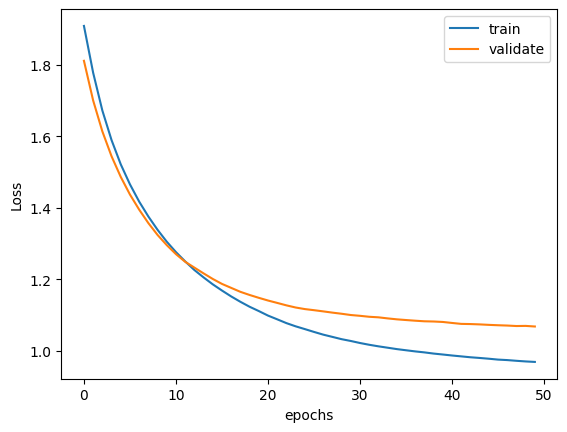

In [ ]:
# Plot Learning Curve
import matplotlib.pyplot as plt  
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

ii. Training Accuracy and Validation Accuracy

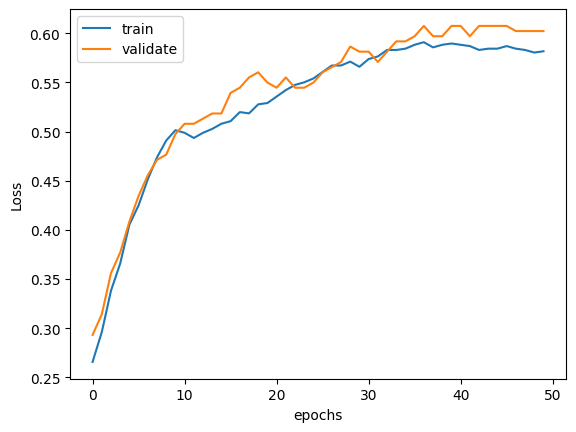

In [ ]:
# Plot Learning Curve
import matplotlib.pyplot as plt  
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validate')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The validation loss is more than the training loss. There is a similarity between training accuracy and validation accuracy suggests that the model is not overfit.

Additionally, the model's performance on test data is not good, it has overall accuracy of 55% and  precision, recall, and recall are 0 for 3, 4 and 8 classes.

D. Design new architecture/update existing architecture in attempt to improve the performance of the model. [2 Marks]

In [ ]:
signalDF2 = read_file('/content/drive/MyDrive/ML/PythonCourse/Signals.csv')
signalDF2 ['Signal_Strength'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: Signal_Strength, dtype: int64

In [ ]:
signalDF2 = duplicate_values(signalDF2)

In [ ]:
signalDF2=signalDF2[(signalDF2['Signal_Strength'] == 4) | (signalDF2['Signal_Strength'] ==5) | (signalDF2['Signal_Strength'] ==6) | (signalDF2['Signal_Strength'] ==7)]

In [ ]:
signalDF2["Signal_Strength"]= signalDF2['Signal_Strength']-4
signalDF2 ['Signal_Strength'].value_counts()

1    577
2    535
3    167
0     53
Name: Signal_Strength, dtype: int64

In [ ]:
X_signal_2 = signalDF2.drop(['Signal_Strength'], axis=1)
y_signal_2 =signalDF2['Signal_Strength']

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_signal_2 ,y_signal_2 , test_size=0.3, random_state=42)
print(np.round((len(X_train_2)/len(signalDF2.index)) * 100,2), "% data is in training set")
print(np.round((len(X_test_2)/len(signalDF2.index)) * 100,2), "% data is in test set")


69.97 % data is in training set
30.03 % data is in test set


In [ ]:
print('Training set', X_train_2.shape, y_train_2.shape)
print('Test set', X_test_2.shape, y_test_2.shape)

Training set (932, 11) (932,)
Test set (400, 11) (400,)


In [ ]:
scaler = StandardScaler().fit(X_train_2)
X_train_2_sc = scaler.transform(X_train_2)
X_test_2_sc = scaler.transform(X_test_2)

In [ ]:
num_classes = 4
y_train_2 = to_categorical(y_train_2, num_classes)
y_test_2_cat=to_categorical(y_test_2,num_classes)

In [ ]:
model_2 = Sequential()

model_2 = Sequential()
model_2.add(InputLayer(input_shape=X_train_2_sc.shape[1],))
model_2.add(Dense(8, activation='relu',kernel_initializer='he_normal'))
#model_2.add(Dense(6, activation='relu',kernel_initializer='he_normal'))
#model_2.add(Dropout(0.5))
#model_2.add(BatchNormalization())
model_2.add(Dense(4, activation = "softmax"))
model_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])
model_2.summary()

print('Training set', X_train_2.shape, y_train_2.shape)
print('Test set', X_test_2.shape, y_test_2.shape)

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_149 (Dense)           (None, 8)                 96        
                                                                 
 dense_150 (Dense)           (None, 4)                 36        
                                                                 
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________
Training set (932, 11) (932, 4)
Test set (400, 11) (400,)


In [ ]:
history_2=model_2.fit(X_train_2_sc , y_train_2, validation_split=0.2, epochs=100, batch_size=30, verbose=2)


Epoch 1/100
25/25 - 1s - loss: 1.9344 - accuracy: 0.2362 - val_loss: 1.8826 - val_accuracy: 0.2781 - 813ms/epoch - 33ms/step
Epoch 2/100
25/25 - 0s - loss: 1.7614 - accuracy: 0.2671 - val_loss: 1.7436 - val_accuracy: 0.2941 - 76ms/epoch - 3ms/step
Epoch 3/100
25/25 - 0s - loss: 1.6236 - accuracy: 0.3087 - val_loss: 1.6313 - val_accuracy: 0.3316 - 74ms/epoch - 3ms/step
Epoch 4/100
25/25 - 0s - loss: 1.5154 - accuracy: 0.3409 - val_loss: 1.5405 - val_accuracy: 0.3529 - 72ms/epoch - 3ms/step
Epoch 5/100
25/25 - 0s - loss: 1.4293 - accuracy: 0.3785 - val_loss: 1.4662 - val_accuracy: 0.3690 - 93ms/epoch - 4ms/step
Epoch 6/100
25/25 - 0s - loss: 1.3622 - accuracy: 0.3946 - val_loss: 1.4058 - val_accuracy: 0.3850 - 79ms/epoch - 3ms/step
Epoch 7/100
25/25 - 0s - loss: 1.3080 - accuracy: 0.4161 - val_loss: 1.3562 - val_accuracy: 0.4064 - 83ms/epoch - 3ms/step
Epoch 8/100
25/25 - 0s - loss: 1.2627 - accuracy: 0.4443 - val_loss: 1.3147 - val_accuracy: 0.4332 - 93ms/epoch - 4ms/step
Epoch 9/100
25

In [ ]:
y_pred_2=model_2.predict(X_test_2_sc)
y_pred_2_final=[]
for i in y_pred_2:
    y_pred_2_final.append(np.argmax(i))
print('Confusion Matrix',metrics.classification_report(y_test_2, y_pred_2_final))

13/13 [==============================] - 0s 1ms/step
Confusion Matrix               precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.70      0.71      0.71       178
           2       0.55      0.60      0.58       162
           3       0.51      0.40      0.45        48

    accuracy                           0.61       400
   macro avg       0.52      0.45      0.47       400
weighted avg       0.61      0.61      0.61       400



E. Plot visuals as in Q3.C and share insights about difference observed in both the models. [3 Marks] 

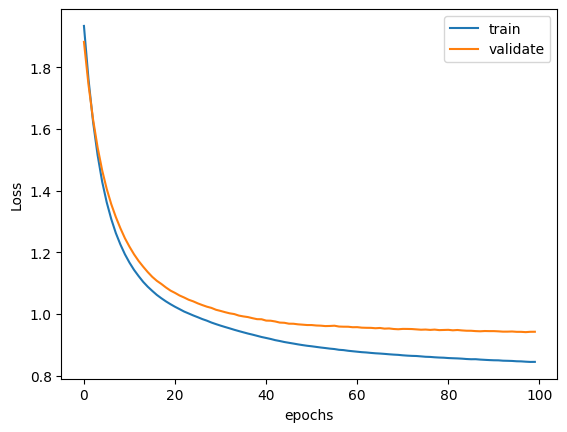

In [ ]:
# Plot Learning Curve
import matplotlib.pyplot as plt  
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='validate')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

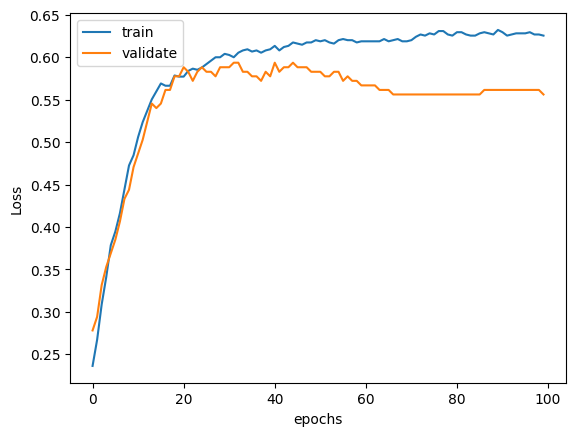

In [ ]:
# Plot Learning Curve
import matplotlib.pyplot as plt  
plt.plot(history_2.history['accuracy'], label='train')
plt.plot(history_2.history['val_accuracy'], label='validate')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(' Base model Confusion Matrix',metrics.classification_report(y_test, y_pred_final))
print('\n Optimized model Confusion Matrix',metrics.classification_report(y_test_2, y_pred_2_final))

 Base model Confusion Matrix               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        13
           2       0.58      0.78      0.66       172
           3       0.52      0.41      0.46       164
           4       0.51      0.44      0.47        50
           5       0.00      0.00      0.00         4

    accuracy                           0.55       408
   macro avg       0.27      0.27      0.27       408
weighted avg       0.51      0.55      0.52       408


 Optimized model Confusion Matrix               precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.70      0.71      0.71       178
           2       0.55      0.60      0.58       162
           3       0.51      0.40      0.45        48

    accuracy                           0.61       400
   macro avg       0.52      0.45      0.47       400
weighted avg 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***
The validation loss and training loss resemble one another. Similarity between training accuracy and validation accuracy suggests that the model is not overfit.


Base model is built with all signal strength 3 to 8 (i.e. 0 to 5 in confusion matrix).

Base model not able to predict signal strength 3, 4 and 8, whose precision, recall and f1-scores are '0'.

Base model accuracty is 55%.

The performance model is with the signal streandth  4 to 7 and it's not considered signal strenth 3 and 8 as it has very few records, which are not going helpful in building the model.

perf model able to predict signal strength 4 with precision - 33% which is better than base model.

over accuracy of perf model increased by 6% from 55 to 61%.


***

# PROJECT OBJECTIVE: To build a digit classifier on the SVHN (Street View Housing Number) dataset. 

1. Data Import and Exploration [5 Marks]

A. Read the .h5 file and assign to a variable. [2 Marks]

In [554]:
#Reading .h5 file and assigning to a variable
autonomous_vehicle = h5py.File('/content/drive/MyDrive/ML/PythonCourse/Autonomous_Vehicles_SVHN_single_grey1.h5', 'r')

B. Print all the keys from the .h5 file. [1 Marks]

In [555]:
print(' Keys from .h5 file  :-', list(autonomous_vehicle.keys()))

 Keys from .h5 file  :- ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


***
There are 6 keys - X_train, X_test, X_val, y_train, y_test and y_val
***

C. Split the data into X_train, X_test, Y_train, Y_test [2 Marks]

In [556]:
X_train_raw = autonomous_vehicle['X_train'][:]
X_test_raw = autonomous_vehicle['X_test'][:]
X_val_raw = autonomous_vehicle['X_val'][:]

y_test_raw = autonomous_vehicle['y_test'][:]
y_train_raw = autonomous_vehicle['y_train'][:]
y_val_raw = autonomous_vehicle['y_val'][:]

In [557]:
X=np.concatenate((X_train_raw, X_test_raw, X_val_raw), axis=0)
y=np.concatenate((y_train_raw, y_test_raw, y_val_raw), axis=0)

In [558]:
X_train_av, X_test_av, y_train_av, y_test_av = train_test_split(X ,y , test_size=0.3, random_state=42)


***
Concatenated all X_train, X_test and X_val to X and y_train, y_test and y_val to y and then splitted to X_train, X_test, y_train and y_test using train_test_split method.

***

2. Data Visualisation and preprocessing [13 Marks]

A. Print shape of all the 4 data split into x, y, train, test to verify if x & y is in sync. [1 Marks]


In [559]:
print('Shape of  X_train :',X_train_av.shape)
print('Shape of  y_train :',y_train_av.shape)
print('Shape of  X_test :',X_test_av.shape)
print('Shape of  y_test :',y_test_av.shape)


Shape of  X_train : (84000, 32, 32)
Shape of  y_train : (84000,)
Shape of  X_test : (36000, 32, 32)
Shape of  y_test : (36000,)


***
As shown above the shape of X_train, y_train and X_test, y_test are in sync
***

B. Visualise first 10 images in train data and print its corresponding labels. [4 Marks]


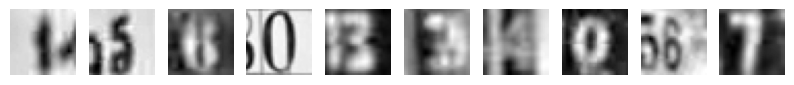

label for each of the above image: [1 5 6 0 3 3 4 0 6 7]


In [560]:
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train_av[i], cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train_av[0:10]))

C. Reshape all the images with appropriate shape update the data in same variable. [3 Marks]


In [561]:
# Flatten the images
svhn_image_vector_size = 32*32
X_train_av = X_train_av.reshape(X_train_av.shape[0], svhn_image_vector_size)
X_test_av = X_test_av.reshape(X_test_av.shape[0], svhn_image_vector_size)



In [562]:
print('Reshape of  X_train :',X_train_av.shape)
print('Rehape of  X_test :',X_test_av.shape)

Reshape of  X_train : (84000, 1024)
Rehape of  X_test : (36000, 1024)


D. Normalise the images i.e. Normalise the pixel values. [2 Marks]


In [563]:
# # normalize inputs from 0-255 to 0-1
X_train_av = X_train_av / 255.0
X_test_av = X_test_av / 255.0

print('After normalize inputs from 0-255 to 0-1, Training set', X_train_av.shape, y_train_av.shape)
print('normalize inputs from 0-255 to 0-1, Test set', X_test_av.shape, y_test_av.shape)

After normalize inputs from 0-255 to 0-1, Training set (84000, 1024) (84000,)
normalize inputs from 0-255 to 0-1, Test set (36000, 1024) (36000,)


E. Transform Labels into format acceptable by Neural Network [2 Marks]


In [567]:
# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train_av = to_categorical(y_train_av, num_classes)
y_test_av_cat=to_categorical(y_test_av,num_classes)

F. Print total Number of classes in the Dataset. [1 Marks]

In [ ]:
pd.Series(y).value_counts()

2    12000
6    12000
7    12000
4    12000
0    12000
3    12000
1    12000
8    12000
5    12000
9    12000
dtype: int64

In [ ]:
print("First 5 training lables as one-hot encoded vectors:\n", y_test_av_cat[:5])

First 5 training lables as one-hot encoded vectors:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


***
There are 10 categories of images, using to_categorical function to get one-hot encoded vector for these 10 categories.
***

3. Model Training & Evaluation using Neural Network [12 Marks]  

A. Design a Neural Network to train a classifier. [3 Marks]


In [568]:

# create model
svhn_model = Sequential()  
svhn_model.add(Dense(256, activation='relu',kernel_initializer='he_uniform',input_shape=(svhn_image_vector_size,))) ###Multiple Dense units with Relu activation
svhn_model.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
svhn_model.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
svhn_model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
svhn_model.add(Dense(10, activation = "softmax"))
svhn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])
svhn_model.summary()


Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 256)               262400    
                                                                 
 dense_189 (Dense)           (None, 64)                16448     
                                                                 
 dense_190 (Dense)           (None, 64)                4160      
                                                                 
 dense_191 (Dense)           (None, 32)                2080      
                                                                 
 dense_192 (Dense)           (None, 10)                330       
                                                                 
Total params: 285,418
Trainable params: 285,418
Non-trainable params: 0
_________________________________________________________________


B. Train the classifier using previously designed Architecture (Use best suitable parameters). [3 Marks]


In [569]:
svhn_history=svhn_model.fit(X_train_av, y_train_av, validation_split=0.2, epochs=200, batch_size=64, verbose=2)


Epoch 1/200
1050/1050 - 9s - loss: 2.2900 - accuracy: 0.1056 - val_loss: 2.2863 - val_accuracy: 0.1101 - 9s/epoch - 9ms/step
Epoch 2/200
1050/1050 - 7s - loss: 1.9857 - accuracy: 0.2432 - val_loss: 1.5975 - val_accuracy: 0.4301 - 7s/epoch - 7ms/step
Epoch 3/200
1050/1050 - 7s - loss: 1.3884 - accuracy: 0.5333 - val_loss: 1.2172 - val_accuracy: 0.6112 - 7s/epoch - 7ms/step
Epoch 4/200
1050/1050 - 7s - loss: 1.1858 - accuracy: 0.6185 - val_loss: 1.1507 - val_accuracy: 0.6364 - 7s/epoch - 7ms/step
Epoch 5/200
1050/1050 - 7s - loss: 1.0922 - accuracy: 0.6519 - val_loss: 1.0754 - val_accuracy: 0.6615 - 7s/epoch - 7ms/step
Epoch 6/200
1050/1050 - 8s - loss: 1.0181 - accuracy: 0.6769 - val_loss: 0.9996 - val_accuracy: 0.6939 - 8s/epoch - 7ms/step
Epoch 7/200
1050/1050 - 6s - loss: 0.9543 - accuracy: 0.6997 - val_loss: 0.9826 - val_accuracy: 0.7000 - 6s/epoch - 6ms/step
Epoch 8/200
1050/1050 - 7s - loss: 0.9067 - accuracy: 0.7157 - val_loss: 0.9097 - val_accuracy: 0.7173 - 7s/epoch - 7ms/step


C. Evaluate performance of the model with appropriate metrics. [2 Marks]


In [571]:
y_pred_av=svhn_model.predict(X_test_av)

1125/1125 [==============================] - 2s 2ms/step


In [572]:
y_pred_av_final=[]
for i in y_pred_av:
    y_pred_av_final.append(np.argmax(i))

In [573]:
print(metrics.classification_report(y_test_av, y_pred_av_final))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3599
           1       0.83      0.85      0.84      3670
           2       0.88      0.83      0.86      3609
           3       0.79      0.80      0.80      3526
           4       0.88      0.86      0.87      3564
           5       0.79      0.83      0.81      3644
           6       0.84      0.82      0.83      3598
           7       0.83      0.89      0.86      3628
           8       0.79      0.80      0.80      3575
           9       0.85      0.79      0.82      3587

    accuracy                           0.83     36000
   macro avg       0.84      0.83      0.83     36000
weighted avg       0.84      0.83      0.83     36000



***
As all classes are balanced well, we could see pretty much good values for precision, recall, f1-score of all 10 classes.

The overall accuracy of the base model is 83%, this can be furthur improved with hyper parameter tuning.
***

D. Plot the training loss, validation loss vs number of epochs and training accuracy, validation accuracy vs number of epochs plot and write your
observations on the same. [4 Marks]

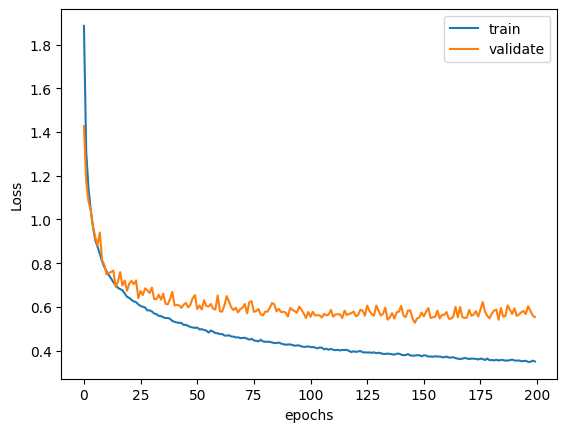

In [534]:
# Plot Learning Curve
import matplotlib.pyplot as plt  
plt.plot(svhn_history.history['loss'], label='train')
plt.plot(svhn_history.history['val_loss'], label='validate')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

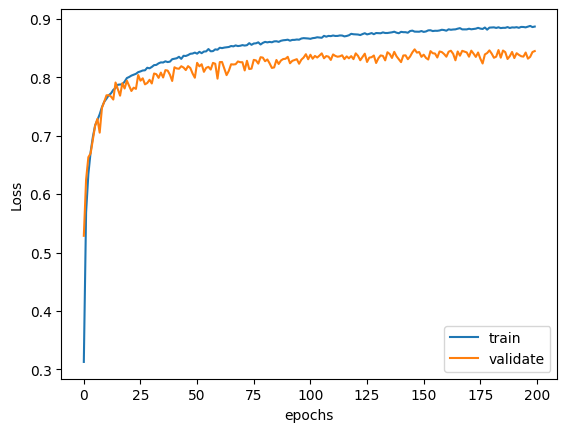

In [535]:
# Plot Learning Curve
import matplotlib.pyplot as plt  
plt.plot(svhn_history.history['accuracy'], label='train')
plt.plot(svhn_history.history['val_accuracy'], label='validate')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

***
**Observations:**

The validation loss and training loss resemble one another. Similarity between training accuracy and validation accuracy suggests that the model is not overfit.

Additionally, the model's performance on test data is strong, with an overall accuracy of 83% and good precision, recall, and recall for all classes.




***